In [1]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping,
    Callable
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
from torch import nn
from torch.utils.data import TensorDataset,DataLoader
from torch.nn import functional as F

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper


## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"
    
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
x = torch.arange(10).reshape((-1,1))
y = torch.arange(10).reshape((-1,1))

# Why Residual is better ?

In [3]:
class Hypo(helper.Module):
    def __init__(self,lr=0.01) -> None:
        super().__init__()
        self.lr = lr
        self.noise_layer = nn.Sequential(
            nn.LazyLinear(out_features=10,bias=False),nn.ReLU(inplace=False),
            )
        self.final = nn.LazyLinear(1,bias=False)
            
    def forward(self, x: torch.Tensor):
        y = self.noise_layer(x) 
        y = self.final(y)
        return F.relu(y)
    
    def loss(self, y_logits, y):
        loss_fn = nn.MSELoss()
        return loss_fn(y_logits,y)  

In [4]:
class SyntheticRegressionData(helper.DataModule):
    def __init__(
        self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32
    ) -> None:
        self.w = w
        self.b = b
        self.noise = noise
        self.num_train = num_train
        self.num_val = num_val
        self.batch_size = batch_size

        n = num_train + num_val
        self.X = torch.normal(5,1,size=(n, len(self.w)))
        noise = torch.randn(size=(n, 1)) * self.noise
        self.y = torch.matmul(self.X, torch.reshape(self.w, (-1, 1))) + b

    def get_dataloader(self, train: bool):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X,self.y),train,i)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset=dataset,batch_size=self.batch_size,shuffle=True)


In [5]:
data = SyntheticRegressionData(w = torch.tensor([1.]),b=0,noise=0)

In [6]:
hypo = Hypo(lr=0.03)
trainer = helper.Trainer(max_epochs=10)

Training the model in cpu


c:\Users\Lenovo\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
trainer = helper.Trainer(max_epochs=10)

Training the model in cpu


In [8]:
torch.allclose(data.X,data.y)

True

In [9]:
torch.allclose(F.relu(data.X),data.y)

True

  0%|          | 0/10 [00:00<?, ?it/s]

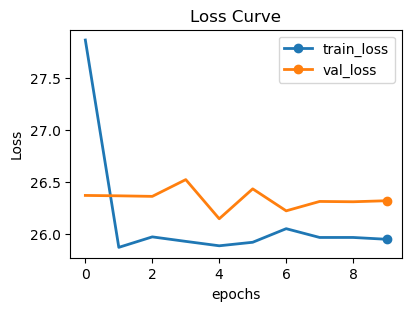

In [10]:
trainer.fit(hypo,data)

In [11]:
class Residual(helper.Module):
    def __init__(self,lr=0.01) -> None:
        super().__init__()
        self.lr = lr
        self.noise_layer = nn.Sequential(
            nn.LazyLinear(out_features=10,bias=False),nn.ReLU(inplace=False),
            )
        self.final = nn.LazyLinear(1,bias=False)
            
    def forward(self, x: torch.Tensor):
        y = self.noise_layer(x) 
        y = self.final(y)
        y += x
        return F.relu(y)
    
    def loss(self, y_logits, y):
        loss_fn = nn.MSELoss()
        return loss_fn(y_logits,y)  

In [12]:
torch.allclose(F.relu(data.X),data.y)

True

In [13]:
res = Residual(lr=0.03)
trainer = helper.Trainer(max_epochs=10)

Training the model in cpu


  0%|          | 0/10 [00:00<?, ?it/s]

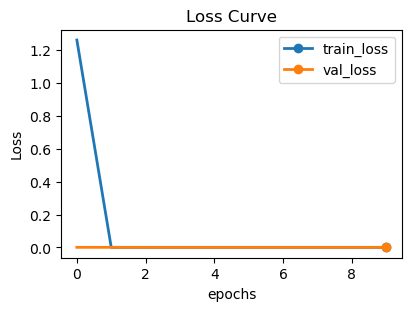

In [14]:
trainer.fit(res,data)

In [15]:
for k,v in res.named_parameters():
    print(k,v)

noise_layer.0.weight Parameter containing:
tensor([[-1.6264e-02],
        [ 1.9612e-07],
        [-6.7706e-01],
        [-7.5204e-01],
        [-1.0438e-01],
        [-4.7089e-01],
        [-7.2010e-01],
        [-2.8342e-01],
        [-7.1881e-04],
        [-1.6282e-01]], requires_grad=True)
final.weight Parameter containing:
tensor([[-0.6903, -0.1620, -0.2357,  0.1683, -0.8820, -0.8458, -0.1193, -0.5639,
         -0.1318,  0.0370]], requires_grad=True)


1. if identity mappings are optimal, the solvers may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings
2. They why Residual network perform better than the Hypo 

In [16]:
for k,v in hypo.named_parameters():
    print(k,v)

noise_layer.0.weight Parameter containing:
tensor([[-0.6089],
        [-0.9734],
        [-0.6948],
        [-0.9698],
        [-1.3078],
        [-2.6008],
        [-1.2485],
        [-1.9719],
        [-0.8349],
        [-0.3584]], requires_grad=True)
final.weight Parameter containing:
tensor([[-0.1727,  0.2413, -0.6562,  0.2718, -0.8968, -2.1886, -0.8963, -1.7715,
         -0.0153, -0.0061]], requires_grad=True)


In hypo , the solver have difficulty in approximating the identity function by multiplying non-Linear layer